In [1]:
# Core
import pandas as pd
import os
import numpy as np
from numpy import set_printoptions, sqrt, argmax, arange
from numpy.random import permutation
import scipy.stats as stats
from itertools import compress
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle

#tsfresh
import tsfresh
from tsfresh.feature_extraction import extract_features, MinimalFCParameters, EfficientFCParameters
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

# Sklearn
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, precision_recall_curve
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve, roc_curve, ConfusionMatrixDisplay
from sklearn.utils import resample
from sklearn.decomposition import PCA

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Self-defined functions
from Utilities import pdVarianceThreshold, pdSelectKBest, train_val_test_split, upsampling, SelectBestClf

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
direc = "E:\\WS4PD_data"
os.chdir(direc)

# Load data

In [11]:
# GENEActiv
device = 'GENEActiv'
day = 2
sb = '7_NYC'
# title_name = 'is_dyskinesia'
# title_name = 'is_bradykinesia'
title_name = 'is_sever_tremor'
# title_name = 'is_tremor'

# Every 30 sec as a trial
# Sliding window: 5 sec
sample_rate = 50 # Hz

dt = 1/sample_rate
time_window = 30 # sec
sliding_window = 10 # sec

#### load sensor feature data
sensor_file_path = os.path.join(direc, "Feature_extraction", device,'day_2',sb + '_features.pkl')
df_sensor_feature = pd.read_pickle(sensor_file_path)

#### Load cilinical feature data
clinical_file_path = os.path.join(direc, 'Feature_extraction','metadata_features.pkl')
df_clinical_feature_all = pd.read_pickle(clinical_file_path)
# select patient
is_sb = df_clinical_feature_all['subject_id'] == sb

# drop subject_id and task_code 
# df_clinical_feature.drop(columns = ['subject_id', 'task_code'])
df_clinical_feature_all = df_clinical_feature_all.drop(columns = 'subject_id')

# One-hot encoding clinical/ categorical features
categorical_columns = df_clinical_feature_all.columns
for column in categorical_columns:
    tempdf = pd.get_dummies(df_clinical_feature_all[column], prefix=column)
    df_clinical_feature_all = pd.merge(
        left=df_clinical_feature_all,
        right=tempdf,
        left_index=True,
        right_index=True,
    )
    df_clinical_feature_all = df_clinical_feature_all.drop(columns=column)
df_clinical_feature_all = df_clinical_feature_all.dropna(axis=1)
df_clinical_feature_sb = df_clinical_feature_all.loc[is_sb]



In [12]:
# Load model and model metadata
model_file_name = 'Finalized_model_' + title_name + '.sav'
model_file_path = os.path.join(direc, "Finalized_Models", model_file_name)
clf = pickle.load(open(model_file_path, 'rb'))

model_metadata_name = 'Metadata_of_finalized_model_' + title_name +'.pkl'
model_metadata_path = os.path.join(direc, "Finalized_Models", model_metadata_name)
df_model_metadata = pd.read_pickle(model_metadata_path)


In [13]:
df_model_metadata.columns

Index(['title', 'max_sample_size', 'upsample_size', 'selected_sensor_features',
       'selected_clinical_features', 'validation_scores_for_all_models',
       'best_clf', 'best_clf_params', 'target_recall', 'best_threshold',
       'finalized_model_file_path', 'F_score', 'Precision', 'Recall'],
      dtype='object')

In [14]:
# select sensor feature
sensor_feature_names = df_model_metadata['selected_sensor_features'].iloc[0]
df_sensor_sf = df_sensor_feature[sensor_feature_names]
print(df_sensor_sf.shape)

(8637, 20)


In [15]:
# select clinical features
clinical_feature_names = df_model_metadata['selected_clinical_features'].iloc[0]
sample_size = df_sensor_feature.shape[0]
selected_clinical_features = df_clinical_feature_sb[clinical_feature_names].iloc[0].values
df_clinical_sf = pd.DataFrame(data = [selected_clinical_features] * sample_size,
            columns = clinical_feature_names)
print(df_clinical_sf.shape)

(8637, 4)


In [16]:
X_test_sf = pd.concat([df_sensor_sf, df_clinical_sf], axis=1) 
print(X_test_sf.shape)

(8637, 24)


In [17]:
# Prediction
yhat = clf.predict_proba(X_test_sf)
# Keep probabilities for the positive outcome only
probs = yhat[:, 1]
# Predict the class using the new threhold 
pred_threshold  = df_model_metadata['best_threshold'].iloc[0]
new_y_pred = probs > pred_threshold

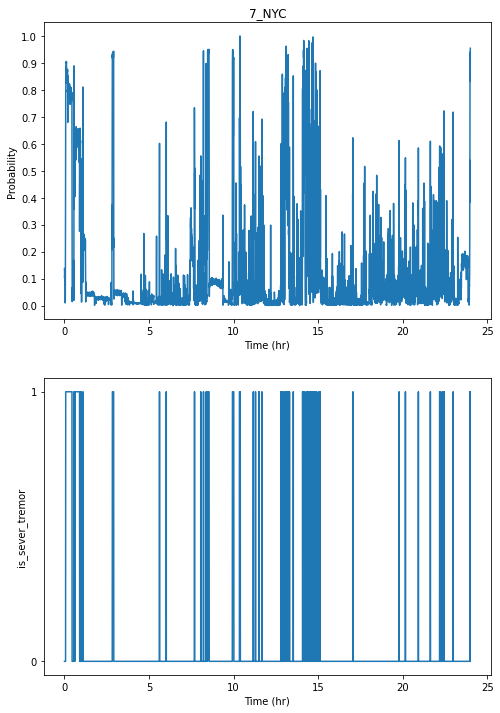

In [18]:
# Plot
dt = 1/(60*6)
x = np.arange(0, dt*len(new_y_pred), dt)

fig, (ax0, ax1) = plt.subplots(2,1, figsize=(8,12))

## Predicted probability 
ax0.plot(x,probs)
# ax0.axvline(x = thresholds[ix], color = 'r', label = 'new threshold')
ax0.set_xlabel('Time (hr)')
ax0.set_ylabel('Probability')
ax0.set_yticks(np.arange(0,1.1,0.1))
ax0.set_title(sb)
## Prediction
ax1.plot(x,new_y_pred)
# ax0.axvline(x = thresholds[ix], color = 'r', label = 'new threshold')
ax1.set_xlabel('Time (hr)')
ax1.set_ylabel(title_name)
ax1.set_yticks([0,1])

# Save figure
file_name = sb + "_" + title_name
plt.savefig(os.path.join(direc, "Finalized_Models", "Prediction_day_" + str(day), file_name))